1.0028634
1.0028633718811601
3.52538496173338e-08


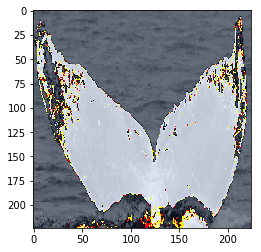

In [30]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_last')
import cv2
from glob import glob
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import tqdm
import cv2
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
import numpy as np
import keras.backend as K
from scipy.spatial import distance
from PIL import Image
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
batch_size = 32
embedding_dim = 50
image_size = 224
path_base = 'D:/data_science/kaggle_whale_detection'
path_train = os.path.join(path_base,'train')
path_test = os.path.join(path_base,'test')
path_model = os.path.join(path_base,'MyModel.hdf5')
path_csv = 'D:/data_science/kaggle_whale_detection/train.csv'
from collections import defaultdict
from sklearn.preprocessing import normalize
class sample_gen(object):
    def __init__(self, file_class_mapping, other_class = "new_whale"):
        self.file_class_mapping= file_class_mapping
        self.class_to_list_files = defaultdict(list)
        self.list_other_class = []
        self.list_all_files = list(file_class_mapping.keys())
        self.range_all_files = list(range(len(self.list_all_files)))

        for file, class_ in file_class_mapping.items():
            if class_ == other_class:
                self.list_other_class.append(file)
            else:
                self.class_to_list_files[class_].append(file)

        self.list_classes = list(set(self.file_class_mapping.values()))
        self.range_list_classes= range(len(self.list_classes))
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        self.class_weight = self.class_weight/np.sum(self.class_weight)

    def get_sample(self):
        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]
        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
        positive_example_1, positive_example_2 = \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]],\
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]
            
        negative_example = None
        while negative_example is None or self.file_class_mapping[negative_example] == \
                self.file_class_mapping[positive_example_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_example = self.list_all_files[negative_example_idx]
        return positive_example_1, negative_example, positive_example_2
    
def read_and_resize(filepath):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize((image_size, image_size))
    return np.array(im, dtype="float32")


def augment(im_array):
    if np.random.uniform(0, 1) > 0.9:
        im_array = np.fliplr(im_array)
    return im_array

def gen(triplet_gen):
    while True:
        list_positive_examples_1 = []
        list_negative_examples = []
        list_positive_examples_2 = []

        for i in range(batch_size):
            positive_example_1, negative_example, positive_example_2 = triplet_gen.get_sample()
            path_pos1 = os.path.join(path_train, positive_example_1)
            path_neg = os.path.join(path_train, negative_example)
            path_pos2 = os.path.join(path_train, positive_example_2)
            
            positive_example_1_img = read_and_resize(path_pos1)
            negative_example_img = read_and_resize(path_neg)
            positive_example_2_img = read_and_resize(path_pos2)

            positive_example_1_img = augment(positive_example_1_img)
            negative_example_img = augment(negative_example_img)
            positive_example_2_img = augment(positive_example_2_img)
            
            list_positive_examples_1.append(positive_example_1_img)
            list_negative_examples.append(negative_example_img)
            list_positive_examples_2.append(positive_example_2_img)

        A = preprocess_input(np.array(list_positive_examples_1))
        B = preprocess_input(np.array(list_positive_examples_2))
        C = preprocess_input(np.array(list_negative_examples))
        
        label = None
        
        yield ({'anchor_input': A, 'positive_input': B, 'negative_input': C}, label)

def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def triplet_loss_np(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = np.square(anchor - positive)
    negative_distance = np.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = np.sqrt(np.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = np.sqrt(np.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = np.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = np.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = np.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = np.log(1 + np.exp(loss))
    return np.mean(loss)

def check_loss():
    batch_size = 10
    shape = (batch_size, 4096)

    p1 = normalize(np.random.random(shape))
    n = normalize(np.random.random(shape))
    p2 = normalize(np.random.random(shape))
    
    input_tensor = [K.variable(p1), K.variable(n), K.variable(p2)]
    out1 = K.eval(triplet_loss(input_tensor))
    input_np = [p1, n, p2]
    out2 = triplet_loss_np(input_np)

    assert out1.shape == out2.shape
    print(np.linalg.norm(out1))
    print(np.linalg.norm(out2))
    print(np.linalg.norm(out1-out2))
check_loss()        

data = pd.read_csv('D:/data_science\kaggle_whale_detection/train.csv')
train, test = train_test_split(data, train_size=0.9, random_state=1337)
file_id_mapping_train = {k: v for k, v in zip(train.Image.values, train.Id.values)}
file_id_mapping_test = {k: v for k, v in zip(test.Image.values, test.Id.values)}
gen_tr = gen(sample_gen(file_id_mapping_train))
gen_te = gen(sample_gen(file_id_mapping_test))
filepath='keras_model_wgtcorr'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
callbacks_list = [checkpoint, early] 

def ShowImg(img):
    plt.figure()
    plt.imshow(img.astype('uint8'))
    plt.show()
    plt.close()
    
batch = next(gen_tr)
img = batch[0]['anchor_input'][1]
img = img[..., ::-1]
ShowImg(img)

cache_dir  = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


In [31]:
from keras.applications.resnet50 import ResNet50
import resnet
from keras.applications.resnet50 import preprocess_input, decode_predictions
#Model definition
def get_model():
    base_model = resnet.ResNet50(weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Dropout(0.6)(x)
    x = Dense(embedding_dim)(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    embedding_model = Model(base_model.input, x, name="embedding")

    input_shape = (image_size, image_size, 3)
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
       
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))

    return embedding_model, triplet_model

In [32]:
cache_dir  = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


import keras
for layer in base_model.layers:
        layer.trainable = False
x = base_model.output
x = keras.layers.Dropout(0.6)(x)
x = keras.layers.Dense(128)(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
embedding_model = Model(base_model.input, x, name="embedding")        

In [33]:
embedding_model, triplet_model = get_model()

In [35]:
for i,layer in enumerate(embedding_model.layers):
    print(i,layer.name,layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_50 False
5 max_pooling2d_2 False
6 res2a_branch2a False
7 bn2a_branch2a False
8 activation_51 False
9 res2a_branch2b False
10 bn2a_branch2b False
11 activation_52 False
12 res2a_branch2c False
13 res2a_branch1 False
14 bn2a_branch2c False
15 bn2a_branch1 False
16 add_17 False
17 activation_53 False
18 res2b_branch2a False
19 bn2b_branch2a False
20 activation_54 False
21 res2b_branch2b False
22 bn2b_branch2b False
23 activation_55 False
24 res2b_branch2c False
25 bn2b_branch2c False
26 add_18 False
27 activation_56 False
28 res2c_branch2a False
29 bn2c_branch2a False
30 activation_57 False
31 res2c_branch2b False
32 bn2c_branch2b False
33 activation_58 False
34 res2c_branch2c False
35 bn2c_branch2c False
36 add_19 False
37 activation_59 False
38 res3a_branch2a False
39 bn3a_branch2a False
40 activation_60 False
41 res3a_branch2b False
42 bn3a_branch2b False
43 activation_61 False
44 res3a_branch2c False
45 res

In [34]:
for layer in embedding_model.layers[175:]:
    layer.trainable = True
for layer in embedding_model.layers[:175]:
    layer.trainable = False    

In [14]:
filepath='keras_model_wgtcorr'
checkpoint = ModelCheckpoint(filepath,mode='max',monitor='val_acc',save_best_only=True,verbose=1)

In [38]:
triplet_model.compile(optimizer=keras.optimizers.Adam(0.01),loss=None)
history = triplet_model.fit_generator(generator=gen_tr,epochs=4,validation_data=gen_te,verbose=1,steps_per_epoch=200,validation_steps=20)

Epoch 1/4
200/200 [==============================] - ETA: 18:08 - loss: 1.00 - ETA: 10:02 - loss: 1.00 - ETA: 7:19 - loss: 1.0022 - ETA: 5:56 - loss: 1.001 - ETA: 5:07 - loss: 1.000 - ETA: 4:34 - loss: 1.001 - ETA: 4:10 - loss: 1.001 - ETA: 3:52 - loss: 1.000 - ETA: 3:38 - loss: 1.001 - ETA: 3:26 - loss: 1.000 - ETA: 3:17 - loss: 1.000 - ETA: 3:09 - loss: 1.000 - ETA: 3:02 - loss: 1.000 - ETA: 2:56 - loss: 1.000 - ETA: 2:51 - loss: 1.000 - ETA: 2:46 - loss: 1.000 - ETA: 2:42 - loss: 1.000 - ETA: 2:38 - loss: 1.000 - ETA: 2:34 - loss: 1.000 - ETA: 2:31 - loss: 1.000 - ETA: 2:29 - loss: 1.000 - ETA: 2:26 - loss: 1.000 - ETA: 2:23 - loss: 1.000 - ETA: 2:21 - loss: 1.000 - ETA: 2:19 - loss: 1.000 - ETA: 2:17 - loss: 1.000 - ETA: 2:15 - loss: 1.000 - ETA: 2:14 - loss: 1.000 - ETA: 2:13 - loss: 1.000 - ETA: 2:12 - loss: 1.000 - ETA: 2:11 - loss: 1.000 - ETA: 2:10 - loss: 1.000 - ETA: 2:09 - loss: 1.000 - ETA: 2:09 - loss: 1.000 - ETA: 2:08 - loss: 1.000 - ETA: 2:07 - loss: 1.000 - ETA: 2:06 

200/200 [==============================] - ETA: 1:59 - loss: 1.000 - ETA: 1:58 - loss: 1.000 - ETA: 1:57 - loss: 1.000 - ETA: 1:58 - loss: 1.000 - ETA: 1:57 - loss: 1.000 - ETA: 1:57 - loss: 1.000 - ETA: 1:56 - loss: 1.000 - ETA: 1:55 - loss: 1.000 - ETA: 1:55 - loss: 1.000 - ETA: 1:54 - loss: 1.000 - ETA: 1:53 - loss: 1.000 - ETA: 1:53 - loss: 1.000 - ETA: 1:52 - loss: 1.000 - ETA: 1:52 - loss: 1.000 - ETA: 1:51 - loss: 1.000 - ETA: 1:51 - loss: 1.000 - ETA: 1:50 - loss: 1.000 - ETA: 1:49 - loss: 1.000 - ETA: 1:49 - loss: 1.000 - ETA: 1:48 - loss: 1.000 - ETA: 1:48 - loss: 1.000 - ETA: 1:47 - loss: 1.000 - ETA: 1:47 - loss: 1.000 - ETA: 1:46 - loss: 1.000 - ETA: 1:45 - loss: 1.000 - ETA: 1:45 - loss: 1.000 - ETA: 1:44 - loss: 1.000 - ETA: 1:44 - loss: 1.000 - ETA: 1:43 - loss: 1.000 - ETA: 1:42 - loss: 1.000 - ETA: 1:42 - loss: 1.000 - ETA: 1:41 - loss: 1.000 - ETA: 1:40 - loss: 1.000 - ETA: 1:40 - loss: 1.000 - ETA: 1:39 - loss: 1.000 - ETA: 1:39 - loss: 1.000 - ETA: 1:38 - loss: 1.0

200/200 [==============================] - ETA: 1:57 - loss: 1.000 - ETA: 2:00 - loss: 0.999 - ETA: 1:58 - loss: 0.999 - ETA: 1:59 - loss: 0.999 - ETA: 1:59 - loss: 0.999 - ETA: 1:58 - loss: 0.999 - ETA: 1:58 - loss: 0.999 - ETA: 1:57 - loss: 0.999 - ETA: 1:56 - loss: 0.999 - ETA: 1:56 - loss: 0.999 - ETA: 1:55 - loss: 0.999 - ETA: 1:54 - loss: 0.999 - ETA: 1:54 - loss: 1.000 - ETA: 1:53 - loss: 0.999 - ETA: 1:53 - loss: 0.999 - ETA: 1:52 - loss: 1.000 - ETA: 1:51 - loss: 0.999 - ETA: 1:51 - loss: 0.999 - ETA: 1:50 - loss: 0.999 - ETA: 1:50 - loss: 0.999 - ETA: 1:49 - loss: 1.000 - ETA: 1:48 - loss: 1.000 - ETA: 1:48 - loss: 1.000 - ETA: 1:47 - loss: 1.000 - ETA: 1:46 - loss: 1.000 - ETA: 1:46 - loss: 1.000 - ETA: 1:45 - loss: 0.999 - ETA: 1:45 - loss: 1.000 - ETA: 1:44 - loss: 1.000 - ETA: 1:43 - loss: 1.000 - ETA: 1:43 - loss: 0.999 - ETA: 1:42 - loss: 0.999 - ETA: 1:42 - loss: 0.999 - ETA: 1:41 - loss: 0.999 - ETA: 1:40 - loss: 1.000 - ETA: 1:40 - loss: 0.999 - ETA: 1:39 - loss: 0.9

200/200 [==============================] - ETA: 1:57 - loss: 1.000 - ETA: 1:59 - loss: 0.999 - ETA: 1:58 - loss: 0.999 - ETA: 1:58 - loss: 0.999 - ETA: 1:58 - loss: 0.999 - ETA: 1:57 - loss: 0.999 - ETA: 1:57 - loss: 0.999 - ETA: 1:57 - loss: 0.999 - ETA: 1:56 - loss: 0.999 - ETA: 1:56 - loss: 0.999 - ETA: 1:55 - loss: 0.999 - ETA: 1:54 - loss: 0.999 - ETA: 1:53 - loss: 0.999 - ETA: 1:53 - loss: 0.999 - ETA: 1:52 - loss: 0.999 - ETA: 1:51 - loss: 0.999 - ETA: 1:51 - loss: 0.999 - ETA: 1:50 - loss: 0.999 - ETA: 1:49 - loss: 0.999 - ETA: 1:49 - loss: 0.999 - ETA: 1:48 - loss: 0.999 - ETA: 1:47 - loss: 0.999 - ETA: 1:47 - loss: 0.999 - ETA: 1:46 - loss: 0.998 - ETA: 1:46 - loss: 0.998 - ETA: 1:45 - loss: 0.998 - ETA: 1:44 - loss: 0.999 - ETA: 1:44 - loss: 0.999 - ETA: 1:43 - loss: 0.999 - ETA: 1:42 - loss: 0.999 - ETA: 1:42 - loss: 0.999 - ETA: 1:41 - loss: 1.000 - ETA: 1:41 - loss: 1.000 - ETA: 1:40 - loss: 0.999 - ETA: 1:39 - loss: 0.999 - ETA: 1:39 - loss: 0.999 - ETA: 1:38 - loss: 1.0

In [16]:
import keras
triplet_model.compile(optimizer=keras.optimizers.Adam(0.01),loss=None,metrics=['accuracy'])

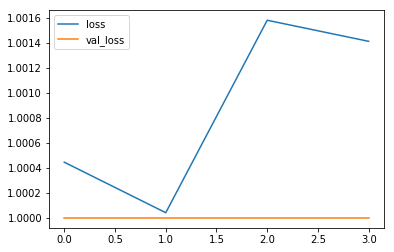

In [41]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [42]:
def data_generator(fpaths, batch=16):
    i = 0
    imgs = []
    fnames = []
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        img = read_and_resize(path)
        imgs.append(img)
        fnames.append(os.path.basename(path))
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            yield fnames, imgs
            
    if i != 0:
        imgs = np.array(imgs)
        yield fnames, imgs
        
    raise StopIteration()

In [43]:
data = pd.read_csv(path_csv)

In [50]:
mapping = {k: v for k,v in zip(data.Image,data.Id)}

In [168]:
mapping

{'00022e1a.jpg': 'w_e15442c',
 '000466c4.jpg': 'w_1287fbc',
 '00087b01.jpg': 'w_da2efe0',
 '001296d5.jpg': 'w_19e5482',
 '0014cfdf.jpg': 'w_f22f3e3',
 '0025e8c2.jpg': 'w_8b1ca89',
 '0026a8ab.jpg': 'w_eaad6a8',
 '0031c258.jpg': 'new_whale',
 '0035632e.jpg': 'w_3d0bc7a',
 '0037e7d3.jpg': 'w_50db782',
 '00389cd7.jpg': 'w_2863d51',
 '0042dcc4.jpg': 'w_6dc7db6',
 '0042ea34.jpg': 'w_968f2ca',
 '00467ae9.jpg': 'w_fd1cb9d',
 '004a97f3.jpg': 'w_60759c2',
 '004c5fb9.jpg': 'w_ab6bb0a',
 '005c57e7.jpg': 'w_79b42cd',
 '006d0aaf.jpg': 'w_c9ba30c',
 '0078af23.jpg': 'w_e6ec8ee',
 '007c3603.jpg': 'new_whale',
 '00863b8c.jpg': 'new_whale',
 '008809b5.jpg': 'w_7e5cc5e',
 '008baccf.jpg': 'w_ab6db0f',
 '0091c92b.jpg': 'w_bc8d634',
 '009dca38.jpg': 'w_b59c523',
 '00a29f63.jpg': 'w_2850471',
 '00aa021c.jpg': 'new_whale',
 '00ab018e.jpg': 'w_51969d2',
 '00ac0e86.jpg': 'w_4be8a3e',
 '00acb5a9.jpg': 'w_c0cfd5b',
 '00ad9219.jpg': 'new_whale',
 '00af84d8.jpg': 'w_339c8ae',
 '00b2c0cd.jpg': 'w_7c7a78c',
 '00b588d6

In [57]:
import os
train_files = glob.glob(os.path.join(path_train,'*jpg'))
test_files = glob.glob(os.path.join(path_test,'*jpg'))

In [156]:
from tqdm import tqdm
train_pred = []
train_file_name = []
for name,img in tqdm(data_generator(train_files,batch=32)):
    predict = embedding_model.predict(img)
    predict = predict.tolist()
    train_pred.append(predict)
    train_file_name.append(name)







0it [00:00, ?it/s]




1it [00:34, 34.48s/it]




2it [00:35, 17.86s/it]




3it [00:36, 12.33s/it]




4it [00:38,  9.55s/it]




5it [00:39,  7.89s/it]




6it [00:40,  6.77s/it]




7it [00:41,  5.98s/it]




8it [00:43,  5.39s/it]




9it [00:44,  4.92s/it]




10it [00:45,  4.55s/it]




11it [00:46,  4.26s/it]




12it [00:48,  4.01s/it]




13it [00:49,  3.79s/it]




14it [00:50,  3.61s/it]




15it [00:51,  3.44s/it]




16it [00:52,  3.30s/it]




17it [00:53,  3.18s/it]




18it [00:55,  3.07s/it]




19it [00:56,  2.97s/it]




20it [00:57,  2.88s/it]




21it [00:58,  2.80s/it]




22it [01:00,  2.73s/it]




23it [01:01,  2.66s/it]




24it [01:02,  2.60s/it]




25it [01:03,  2.55s/it]




26it [01:05,  2.50s/it]




27it [01:06,  2.46s/it]




28it [01:07,  2.42s/it]




29it [01:08,  2.38s/it]




30it [01:10,  2.34s/it]




31it [01:11,  2.30s/it]




32it [01:12,  2.27s/it]




33it [01:13,  2.24s/it]




34it [01:15,  2.21s/it]




35it [01:16,  2.18s/it]




3

286it [06:22,  1.34s/it]




287it [06:23,  1.34s/it]




288it [06:24,  1.33s/it]




289it [06:25,  1.33s/it]




290it [06:26,  1.33s/it]




291it [06:28,  1.33s/it]




292it [06:29,  1.33s/it]




293it [06:30,  1.33s/it]




294it [06:31,  1.33s/it]




295it [06:33,  1.33s/it]




296it [06:34,  1.33s/it]




297it [06:35,  1.33s/it]




298it [06:36,  1.33s/it]




299it [06:38,  1.33s/it]




300it [06:39,  1.33s/it]




301it [06:40,  1.33s/it]




302it [06:41,  1.33s/it]




303it [06:43,  1.33s/it]




304it [06:44,  1.33s/it]




305it [06:45,  1.33s/it]




306it [06:46,  1.33s/it]




307it [06:48,  1.33s/it]




308it [06:48,  1.33s/it]






In [117]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_pred)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=6, p=2, radius=1.0)

In [124]:
dist_test, neighbours_test = neigh.kneighbors(test_pred)

In [160]:
train_pred.shape

(308,)

In [118]:
from tqdm import tqdm
test_pred = []
test_file_name = []
for name,img in tqdm(data_generator(test_files,batch=32)):
    predict = embedding_model.predict(img)
    predict = predict.tolist()
    test_pred.append(predict)
    test_file_name.append(name)





0it [00:00, ?it/s]



1it [00:00,  2.14it/s]



2it [00:00,  2.35it/s]



3it [00:01,  2.37it/s]



4it [00:01,  2.35it/s]



5it [00:02,  2.34it/s]



6it [00:02,  2.36it/s]



7it [00:02,  2.37it/s]



8it [00:03,  2.35it/s]



9it [00:03,  2.34it/s]



10it [00:04,  2.33it/s]



11it [00:04,  2.32it/s]



12it [00:05,  2.30it/s]



13it [00:05,  2.28it/s]



14it [00:06,  2.29it/s]



15it [00:06,  2.28it/s]



16it [00:06,  2.29it/s]



17it [00:07,  2.30it/s]



18it [00:07,  2.29it/s]



19it [00:08,  2.29it/s]



20it [00:08,  2.29it/s]



21it [00:09,  2.29it/s]



22it [00:09,  2.29it/s]



23it [00:10,  2.27it/s]



24it [00:10,  2.27it/s]



25it [00:10,  2.28it/s]



26it [00:11,  2.29it/s]



27it [00:11,  2.29it/s]



28it [00:12,  2.29it/s]



29it [00:12,  2.29it/s]



30it [00:13,  2.28it/s]



31it [00:13,  2.29it/s]



32it [00:14,  2.28it/s]



33it [00:14,  2.27it/s]



34it [00:15,  2.26it/s]



35it [00:15,  2.26it/s]



36it [00:15,  2.27it/s]



37it [00:16

KeyboardInterrupt: 

In [89]:
train_pred = np.reshape(train_pred,(-1,16,50))

ValueError: cannot reshape array of size 616 into shape (16,50)

In [175]:
preds_str = []

for filepath, distance, neighbour_ in zip(test_files, dist_test, neighbours_test):
    sample_result = []
    sample_classes = []
    for d, n in zip(distance, neighbour_):
        train_file = train_files[n].split(os.sep)[-1]
        class_train = mapping[train_file]
        sample_classes.append(class_train)
        sample_result.append((class_train, d))

    if "new_whale" not in sample_classes:
        sample_result.append(("new_whale", 0.001))
    sample_result.sort(key=lambda x: x[1])
    sample_result = sample_result[:5]
    preds_str.append(" ".join([x[0] for x in sample_result]))

In [176]:
print(preds_str)

['w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_379785d', 'w_b6689cc w_715d152 w_dcb4be9 w_656afeb w_37

In [207]:
pred_str=[]
for file, dist,neighbour_ in (zip(test_files,dist_test,neighbours_test)):
    sample_class = []
    sample_result = []
    for d,n in (zip(dist,neighbour_)):
        train_file = train_files[n].split(os.sep)[-1]
        cl = mapping[train_file]
        sample_class.append(cl)
        sample_result.append((cl,d))
    if 'new_whale' not in sample_class:
        sample_result.append(('new_whale',0))
    sample_result.sort(key = lambda x: x[1])
    sample_result = sample_result[:5]
    pred_str.append(" ".join([x[0] for x in sample_result]))

In [208]:
cl

'w_9948a99'